In [6]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import seaborn as sns
import datetime
import random

def round_sort_cols(df):
    df.accuracy =df.accuracy.astype(float).round(3)
    df.TPR = df.TPR.astype(float).round(3)
    df.FPR = df.FPR.astype(float).round(3)
    return df[['device', 'sections', 'window_size', 'threshold','accuracy', 'TP', 'FP', 'TN',
       'FN', 'TPR', 'FPR']]

In [129]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()
device_names = [x[7:-4] for x in trip_names[0]]

In [162]:
best_run_df = pd.DataFrame(columns=['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'TPR', 'FPR'])

In [209]:
# for trip_nr in range(3):
#     for dev_nr in range(5):
#         trip_df=trip_dfs[trip_nr][dev_nr]
#         trip_df['offset_filt']=trip_df.offset.ewm(span=3).mean()

In [217]:
device_names

['GlobalSat', 'GoPro downsampled (last)', 'GoPro', 'P20', 'S9']

# finding winmdow size and threshold

In [224]:

A13_sections = ['A', 'M']
ring_sections = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
curve_sections = ['B', 'D', 'F', 'H', 'J', 'L']
no_curve_sections = ['A', 'C', 'E', 'G','I', 'K', 'M']

In [80]:
for window_size in [8]:#np.arange(8,1,-1):
    min_dist = 5 # for baseline, only consider intervals that are at least min_dist seconds away from a lane change annotation
    sections = 'all' 
    signal_col = 'offset'

    fragments_positive = []
    baseline_fragments_alltrips_alldevs = []

    dev_nrs = [0,1,3,4]

    for dev_nr in dev_nrs: # skip 2 which is original gopro signal before downsampling
        dev_name = device_names[dev_nr]

        baseline_fragments_dev = extract_baseline_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size, min_dist)
        baseline_fragments_alltrips_alldevs.extend(baseline_fragments_dev)
        lanechange_fragments_dev = extract_lanechange_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size)
        lanechange_fragments_dev = make_lanechange_fragments_unidirectional(lanechange_fragments_dev,signal_col)

        fragments_positive.extend(lanechange_fragments_dev) #positive class



    # get same amount of negative traces as positive traces
    random.seed(42)
    fragments_negative = random.sample(baseline_fragments_alltrips_alldevs, len(fragments_positive))

    # print(f'''Extracted {len(fragments_positive)} sections with lane change, and {len(baseline_fragments_alltrips_alldevs)} with no lane change
    # out of which {len(fragments_negative)} fragments were drawn (without replacement)''')
    
    ## iterate over threshold values
    dev_name = str(dev_nrs)
    result_df = pd.DataFrame(columns=['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'TPR', 'FPR'])
    for threshold in np.arange(0,2,0.1): 
        _,_, TP, FP, TN, FN, accuracy,TPR,FPR = get_results(fragments_positive, fragments_negative, threshold)
        result_df.loc[len(result_df), :] =  (dev_name, sections, window_size, threshold, TP, FP, TN, FN, accuracy, TPR, FPR)
    best_run = result_df.loc[result_df.accuracy.astype(float).idxmax()]
    best_run_df.loc[len(best_run_df),:] = best_run
    
    result_df = round_sort_cols(result_df)


    result_df.to_csv(f'results/alldevs_curve_W{window_size}.csv')
best_run_df=round_sort_cols(best_run_df)
best_run_df.to_csv(f'results/best_runs.csv')
    


ignored_fragment


NameError: name 'best_run_df' is not defined

# A closer look at false predictions

In [77]:
window_size=6
min_dist = 5 # for baseline, only consider intervals that are at least min_dist seconds away from a lane change annotation
sections = 'all'
signal_col = 'offset'
threshold = 1.5
dev_nr = 4 #1,3,4
trip_nr = 2
# baseline_fragments_dev = extract_baseline_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size, min_dist)
# lanechange_fragments_dev = extract_lanechange_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size)
# lanechange_fragments_dev = make_lanechange_fragments_unidirectional(lanechange_fragments_dev,signal_col)
trip_df, lca_df, trip_name = selector(trip_dfs, lca_dfs, trip_names, trip_nr, dev_nr, sections)
fragments_positive = extract_lanechange_fragments_trip(signal_col, trip_df, lca_df, window_size)
baseline_fragments = extract_baseline_fragments_trip(signal_col, trip_df, lca_df, window_size, min_dist)
fragments_positive = make_lanechange_fragments_unidirectional(fragments_positive,signal_col)
# get same amount of negative traces as positive traces
random.seed(42)
fragments_negative = random.sample(baseline_fragments, len(fragments_positive))

y_true,y_predict, TP, FP, TN, FN, accuracy,TPR,FPR = get_results(fragments_positive, fragments_negative, threshold)



y_df = pd.DataFrame({'y_true':y_true, 'y_predict': y_predict})
y_df['FP'] = (y_df.y_true==0)&(y_df.y_predict==1)
y_df['FN'] = (y_df.y_true==1)&(y_df.y_predict==0)
y_df_pos = y_df[y_df.y_true==1]
y_df_neg = y_df[y_df.y_true==0].reset_index(drop=True)

FN_idxs = y_df_pos[y_df_pos.FN==True].index
FP_idxs = y_df_neg[y_df_neg.FP==True].index

FN_fragments = [fragments_positive[x] for x in FN_idxs]
FP_fragments = [fragments_negative[x] for x in FP_idxs]

# pd.concat(FN_fragments).to_csv(f'results/FN_fragments_dev{dev_nr}_trip{trip_nr+1}.csv')
# pd.concat(FP_fragments).to_csv(f'results/FP_fragments_dev{dev_nr}_trip{trip_nr+1}.csv')

# Plotting

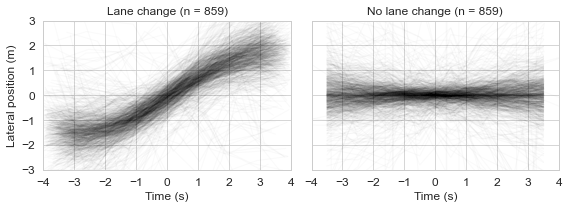

In [127]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
for fragment_pos in fragments_positive:
    axs[0].plot(fragment_pos.t_fragment, fragment_pos.offset_pos-fragment_pos.offset_pos.mean() , alpha=0.02, c='k')#-fragment_pos.offset_pos.loc[abs(fragment_pos.t_fragment).idxmin()]
    axs[0].set_ylim(-3,3)
for fragment_neg in fragments_negative:
    axs[1].plot(fragment_neg.t_fragment, fragment_neg.offset-fragment_neg.offset.mean() , alpha=0.02, c='k')
    
axs[0].set_xlim(-window_size/2,window_size/2)
axs[1].set_xlim(-window_size/2,window_size/2)
axs[0].set_title(f'Lane change (n = {len(fragments_positive)})', size=12)
axs[1].set_title(f'No lane change (n = {len(fragments_negative)})',size=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
axs[0].tick_params(axis='y', labelsize=12 )
axs[0].tick_params(axis='x', labelsize=12 )
axs[1].tick_params(axis='x', labelsize=12 )
axs[0].set_xlabel('Time (s)', size=12)
axs[1].set_xlabel('Time (s)', size=12)
axs[0].set_ylabel('Lateral position (m)', size=12)
# axs[0].text(-0.2,-2.8,"$t_{LC}$",size=14)
# plt.grid(axis='y')
# axs[0].set_xticklabels(['$-3$','$-2$','$-1$', '$0t_{LC}$', '$1$', '$2$', '$3$'])
plt.tight_layout()
axs[0].xaxis.set_ticks(np.arange(-4,5,1))
axs[1].xaxis.set_ticks(np.arange(-4,5,1))
plt.savefig('figures/positive_negative_fragments2.png', dpi=2000, bbox_inches='tight')

In [119]:
np.arange(-4,5,1)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

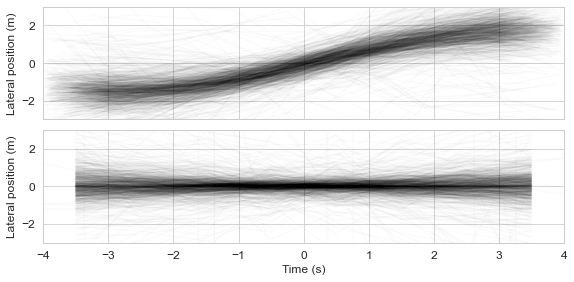

In [103]:
sns.set_style('whitegrid')
sns.set_context('paper')
fig, axs = plt.subplots(2,1,figsize=(8,4),sharex=True,sharey=True)
for fragment_pos in fragments_positive:
    axs[0].plot(fragment_pos.t_fragment, fragment_pos.offset_pos-fragment_pos.offset_pos.mean() , alpha=0.02, c='k')#-fragment_pos.offset_pos.loc[abs(fragment_pos.t_fragment).idxmin()]

for fragment_neg in fragments_negative:
    axs[1].plot(fragment_neg.t_fragment, fragment_neg.offset-fragment_neg.offset.mean() , alpha=0.02, c='k')

axs[0].set_ylim(-3,3)
axs[0].set_xlim(-window_size/2,window_size/2)
axs[1].set_xlim(-window_size/2,window_size/2)
# axs[0].set_title(f'Lane change (n={len(fragments_positive)})')
# axs[1].set_title(f'No lane change (n={len(fragments_negative)})')

# axs[0].set_xlabel('Time (s)', size=12)
axs[1].set_xlabel('Time (s)', size=12)
axs[0].set_ylabel('Lateral position (m)',size=12)
axs[1].set_ylabel('Lateral position (m)', size=12)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
axs[0].tick_params(axis='y', labelsize=12 )
# axs[0].text(-0.2,-2.8,"$t_{LC}$",size=14)
# plt.grid(axis='y')
# axs[0].set_xticklabels(['$-3$','$-2$','$-1$', '$0t_{LC}$', '$1$', '$2$', '$3$'])
plt.savefig('figures/positive_negative_fragments.png', dpi=600, bbox_inches='tight')

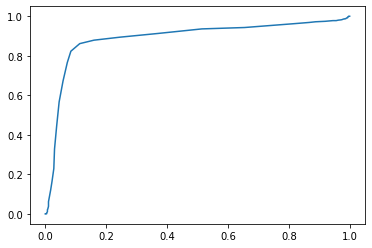

In [96]:
plt.plot(result_df.FPR, result_df.TPR)

In [81]:
len(fragments_positive)

645

In [91]:
fragments_positive[0]

,t,date,lat_gps,lon_gps,alt,speed,speed3D,fix,precision,speed_haversine,...,lon,lat,strategy metric_road,chunk_match_ix_road,order_road,x,y,t_fragment,relative_signal,offset_pos
1,327.050037,2021-06-04 08:07:25.050000+00:00,51.990070,4.391526,-7.615758,26.941,97.200,3.0,130.0,26.881497,...,4.391636,51.989984,0.979971,1,171,86618.63419,445089.8165,-0.496811,0.000000,-4.669011
2,328.043659,2021-06-04 08:07:26.043000+00:00,51.989841,4.391639,-7.664758,26.677,96.156,3.0,130.0,26.455484,...,4.391737,51.989753,0.979971,1,172,86625.21900,445064.0227,0.496811,-0.854715,-3.814296


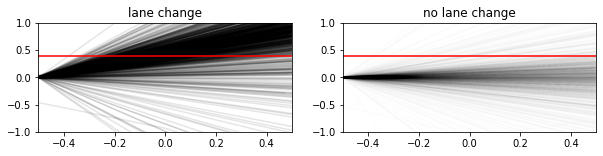

In [114]:
fig,axs=plt.subplots(1,2,figsize=(10,2))
for fragment_pos in fragments_positive: 
    axs[0].plot(fragment_pos.t_fragment, fragment_pos.offset_pos-fragment_pos.offset_pos.iloc[0], color='k', alpha=0.1)
for fragment_neg in fragments_negative: 
    axs[1].plot(fragment_neg.t_fragment, fragment_neg.offset - fragment_neg.offset.iloc[0], color='k', alpha=0.01)

axs[0].set_title('lane change')
axs[0].set_xlim(-0.5,0.5)
axs[0].set_ylim(-1,1)

axs[1].set_xlim(-0.5,0.5)
axs[1].set_ylim(-1,1)


axs[1].set_title('no lane change')

axs[0].axhline(.4, color='red')
axs[1].axhline(.4, color='red')



In [ ]:
a

# plotting

In [9]:
from analysis_helpers import plot_fragments_offset_with_baseline

# select n random fragments for 3-pane plot

random.seed(42)
fragment_dfs_baseline=random.sample(baseline_fragments_alltrips, n_samples=110)



fragments = extract_lanechange_fragments_alltrips(plot_col, trip_dfs, trip_names, lca_dfs, device_nr, sections, window_size)

params = {'ylims': (-4,4),
          'xlims': (-4,4),
         'alpha': 0.05,
         'ylabel': 'relative lateral\ndistance (m)',
         'xlabel': 'time since lane change (s)'}


# plot_fragments_offset(fragments, 'relative_signal', params)
plot_fragments_offset_with_baseline(fragments, fragment_dfs_baseline, 'relative_signal', params)

# in case of velocity measures, use:
# plot_fragments(fragments, plot_col, params)

# plt.savefig('figures/lanechanges_baseline.png', dpi=600, bbox_inches='tight')

TypeError: sample() got an unexpected keyword argument 'n_samples'

In [ ]:
def get_results(fragments_positive, fragments_negative, threshold):
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    y_true = []
    y_score = []

    for fragment_pos in fragments_positive:
        y_true.append(1)
        offset_diff = fragment_pos.offset_pos.iloc[-1] - fragment_pos.offset_pos.iloc[0]
        if offset_diff > threshold: #if positive class is assigned:
            TP+=1
            y_score.append(1)
        else:
            FN+=1
            y_score.append(0)

    for fragment_neg in fragments_negative:
        y_true.append(0)
        offset_diff = fragment_neg.offset.iloc[-1] - fragment_neg.offset.iloc[0]
        if offset_diff > threshold: #if positive class is assigned:
            FP+=1
            y_score.append(1)
        else:
            TN +=1
            y_score.append(0)
            
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    return y_true, y_score, TP, FP, TN, FN, accuracy, TPR, FPR

# Plot the lane change in methods figure

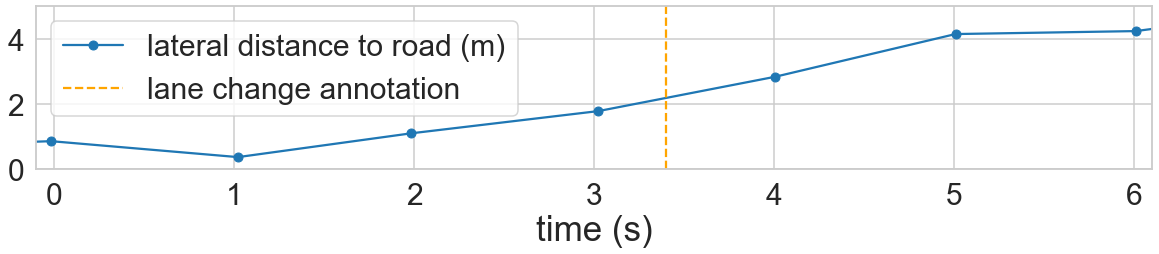

In [195]:
sns.set_style('whitegrid')
sns.set_context('talk')
fig,ax=plt.subplots(figsize=(20,3))
trip_df = trip_dfs[2][1]
fragment = trip_df[trip_df.t.between(1414,1423)]
plt.plot(fragment.t-fragment.t.iloc[0]-1, fragment.offset, marker = 'o', label='lateral distance to road (m)')
ax.set_ylim(0,5)
ax.set_xlim(-.1,6.1)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
ax.set_xlabel('time (s)', size=35)
# ax.set_ylabel('lateral\ndist. (m)', size=35) 
ax.axvline(3.4, c='orange', label = 'lane change annotation', linestyle='--')
ax.legend(prop={'size': 30})

plt.savefig('figures/lateral_dist_methods_with_annotation.png', dpi=60, bbox_inches='tight')

In [120]:
device_names

['GlobalSat', 'GoPro downsampled (last)', 'GoPro', 'P20', 'S9']